In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

from string import punctuation
from nltk import ngrams
import nltk
from nltk import collocations 
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords

from collections import Counter

import time

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
positive = pd.read_csv('C:/Ангелина/Data Sience/5 четверть/Введение в обработку ест языка/2/positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('C:/Ангелина/Data Sience/5 четверть/Введение в обработку ест языка/2/negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)
df.head()

,text,label
0,"@first_timee хоть я и школота, но поверь, у на...",positive
1,"Да, все-таки он немного похож на него. Но мой ...",positive
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,positive
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",positive
4,@irina_dyshkant Вот что значит страшилка :D\nН...,positive


In [4]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label, random_state=42)

In [5]:
nltk.download('genesis')
nltk.download('stopwords')
nltk.download('punkt')

noise = stopwords.words('russian') + list(punctuation)

[nltk_data] Downloading package genesis to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


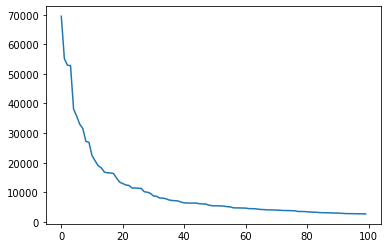

In [6]:
corpus = [token for tweet in df.text for token in word_tokenize(tweet) if token not in punctuation]
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])

first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

### Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой


Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [7]:
# Отсечки по частотности
high = 40
low = 200

high_freq = [token[0] for token in freq_dict_sorted[:high]]
medium_freq = [token[0] for token in freq_dict_sorted[high:low]]
low_freq = [token[0] for token in freq_dict_sorted[low:]]

print(high_freq)

['не', 'и', 'в', 'я', 'RT', 'на', 'http', 'что', 'с', 'а', '...', 'меня', 'у', 'как', 'так', 'D', 'это', 'мне', 'все', 'ты', 'но', "''", 'Я', '``', 'то', '..', 'по', 'уже', 'за', 'же', 'ну', 'А', 'только', 'бы', 'еще', 'да', 'вот', 'тебя', 'нет', 'когда']


In [8]:
def train_lr(stop_words):
    vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words)
    bow = vec.fit_transform(x_train) 
    lr = LogisticRegression(random_state=42, max_iter=500)
    lr.fit(bow, y_train)
    pred = lr.predict(vec.transform(x_test))

    return pred

In [9]:
%%time

labels = ['High:', 'Medium:', 'Low:']
params = [noise+medium_freq+low_freq,
          noise+high_freq+low_freq,
          noise+high_freq+medium_freq]

for label, param in zip(labels, params):
    pred = train_lr(param)
    print(label, classification_report(pred, y_test), sep='\n')
    print('')

High:
              precision    recall  f1-score   support

    negative       0.80      0.58      0.67     38970
    positive       0.42      0.68      0.52     17739

    accuracy                           0.61     56709
   macro avg       0.61      0.63      0.60     56709
weighted avg       0.68      0.61      0.62     56709


Medium:
              precision    recall  f1-score   support

    negative       0.43      0.65      0.52     18531
    positive       0.77      0.58      0.66     38178

    accuracy                           0.60     56709
   macro avg       0.60      0.62      0.59     56709
weighted avg       0.66      0.60      0.62     56709


Low:
              precision    recall  f1-score   support

    negative       0.80      0.75      0.77     29963
    positive       0.74      0.79      0.76     26746

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709

__Вывод:__ Обучение на словах имеющих низкую частотность даёт лучшие результаты

### Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [10]:
stop_words = stopwords.words('russian')
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words)
bow = vec.fit_transform(x_train) 
lr = LogisticRegression(random_state=42, max_iter=500)
lr.fit(bow, y_train)
pred = lr.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     28104
    positive       1.00      1.00      1.00     28605

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



In [11]:
# Выведем 40 важнейших признаков
feat_importance = list(zip(vec.get_feature_names(), lr.coef_[0]))
feat_importance = sorted(feat_importance, key=lambda x: abs(x[1]), reverse=True)[:40]

for i, feat in enumerate(feat_importance):
    print(f'{i+1}) {feat[0]}')

1) (
2) )
3) d
4) ^_^
5) |
6) -/
7) dd
8) о_о
9) ddd
10) o_o
11) do_or_die_xxx
12) to_over_kill
13) -d
14) dddd
15) белый
16) horanso_on
17) ddddd
18) reno_oppa
19) cio_optimal
20) prisonero_o
21) *
22) rt
23) _do_or_die__
24) :
25) =^_^=
26) alekseevao_o
27) kota_oo_oo
28) lponomarenko_o
29) do_or_pie_
30) http
31) dddddd
32) radio_of_moon
33) july_to_october
34) o_obnulyay
35) mo_onmery
36) boo_ohoo
37) leto_on_mars
38) ||
39) з
40) o_olshik


Из списка выше видно, что наиболее значимыми фичами являются части смайликов.

### Задание 3.

1) сравнить count/tf-idf/hashing векторайзеры/полносвязанную сетку (построить classification_report)

2) подобрать оптимальный размер для hashing векторайзера 

3) убедиться что для сетки нет переобучения

In [12]:
stop_words = noise+high_freq+medium_freq 

params = [
    ('Count', CountVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words)),
    ('TF-IDF', TfidfVectorizer(ngram_range=(1, 1), tokenizer=word_tokenize, stop_words=stop_words))
]

for i in range(1024, 10240+1, 1024):
    params.append((f'Hashing ({i})', HashingVectorizer(n_features=i)))

for label, vectorizer in params:
    start_time = time.time()

    bow = vectorizer.fit_transform(x_train) 
    lr = LogisticRegression(random_state=42, max_iter=500)
    lr.fit(bow, y_train)
    pred = lr.predict(vectorizer.transform(x_test))
    print(f'{label} ({round(time.time() - start_time)} sec)',
          classification_report(pred, y_test),
          sep='\n')

    print('\n')

Count (59 sec)
              precision    recall  f1-score   support

    negative       0.80      0.75      0.77     29963
    positive       0.74      0.79      0.76     26746

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



TF-IDF (51 sec)
              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     27849
    positive       0.77      0.76      0.76     28860

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



Hashing (1024) (5 sec)
              precision    recall  f1-score   support

    negative       0.63      0.65      0.64     27165
    positive       0.67      0.65      0.66     29544

    accuracy                           0.65     56709
   macro avg       0.65      0.65      0.65     56709
weighted avg    

В данном случае CountVectorizer показал лучшие результаты.<br>
HashingVectorizer работает значительно быстрее остальных, однако предсказывает он хуже.<br>
Оптимальный размер для HashingVectorizer: 10240